# Tarea
__Estudiante:__ Estefania Aracena Vallejos

__Curso:__ Teoría de Decisiones y Complejidad en Ciencias Sociales


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
import matplotlib.pyplot as plt

df = pd.read_excel('Datos2015.xlsx', header=0)
df = df.drop(['Sujeto_número', 'orden de presentación'], axis=1)
df.head(5)

,"+10k, .05","+10k, .95","+50k, .05","+50k, .95","+90k, .05","+90k, .95","-10k, .05","-10k, .95","-50k, .05","-50k, .95","-90k, .05","-90k, .95"
0,2000,9500,14000,45000,15000,85000,-100,-500,-1000,-1000,-100,-10000
1,500,10000,15000,45000,15000,90000,-500,-100,-100,-1000,-500,-5000
2,100,9000,25000,50000,15000,85000,-1000,-1000,-1000,-15000,-1000,-20000
3,500,9000,8000,40000,15000,80000,-1000,-500,-5000,-500,-5000,-15000
4,1000,9000,10000,40000,10000,85000,-1000,-5000,-500,-10000,-10000,-20000


In [2]:
#Procesamiento set de datos

#Eliminar nombre columnas
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(" ", "")

def parse_column(colname):
    # Ejemplo: "+10k,.05"
    sign = 1 if "+" in colname else -1
    amount_str, prob_str = colname.split(",")
    amount = float(amount_str.replace("+","").replace("-","").replace("k","")) * 1000
    prob = float(prob_str)
    return sign * amount, prob

data = []

for col in df.columns:
    outcome, p = parse_column(col)
    for i in range(len(df)):
        CE = df.loc[i, col]
        data.append({
            "outcomes": [outcome, 0],
            "probs": [p, 1 - p],
            "CE": CE
        })

print("Largo de data =", len(data))
print(data[:5])

Largo de data = 768
[{'outcomes': [10000.0, 0], 'probs': [0.05, 0.95], 'CE': np.int64(2000)}, {'outcomes': [10000.0, 0], 'probs': [0.05, 0.95], 'CE': np.int64(500)}, {'outcomes': [10000.0, 0], 'probs': [0.05, 0.95], 'CE': np.int64(100)}, {'outcomes': [10000.0, 0], 'probs': [0.05, 0.95], 'CE': np.int64(500)}, {'outcomes': [10000.0, 0], 'probs': [0.05, 0.95], 'CE': np.int64(1000)}]


In [3]:
#Definimos V(x)
def v_of_x(x, alpha, beta, lam):
    x = np.array(x, dtype=float)
    out = np.zeros_like(x)
    pos = x >= 0
    out[pos]  = np.power(x[pos], alpha)
    out[~pos] = - lam * np.power(-x[~pos], beta)
    return out
#Definimos W(p) 
def w_transform(p, gamma):
    p = np.clip(p, 1e-12, 1 - 1e-12)
    num = p ** gamma
    den = (p ** gamma + (1 - p) ** gamma) ** (1/gamma)
    return num / den
#Definimos V(f)
def prospect_value(outcomes, probs, alpha, beta, lam, gamma, delta):
    outcomes = np.array(outcomes, dtype=float)
    probs = np.array(probs, dtype=float)

    pos_mask = outcomes > 0
    neg_mask = outcomes < 0

    V = 0.0

    #Si es ganancia
    if pos_mask.any():
        x_pos = outcomes[pos_mask]
        p_pos = probs[pos_mask]

        order = np.argsort(-x_pos)  # descendente
        x_p = x_pos[order]
        p_p = p_pos[order]

        cum = np.cumsum(p_p[::-1])[::-1]
        cum_next = np.concatenate([cum[1:], [0.0]])

        w_cum = w_transform(cum, gamma)
        w_cum_next = w_transform(cum_next, gamma)

        pi = w_cum - w_cum_next
        V += np.sum(pi * v_of_x(x_p, alpha, beta, lam))

    #Si es pérdida
    if neg_mask.any():
        x_neg = outcomes[neg_mask]
        p_neg = probs[neg_mask]

        order = np.argsort(x_neg)  # más negativo primero
        x_n = x_neg[order]
        p_n = p_neg[order]

        cum = np.cumsum(p_n)
        cum_prev = np.concatenate([[0.0], cum[:-1]])

        w_cum = w_transform(cum, delta)
        w_cum_prev = w_transform(cum_prev, delta)

        pi = w_cum - w_cum_prev
        V += np.sum(pi * v_of_x(x_n, alpha, beta, lam))

    return V

#Cálculo de SSE para optimización
def sse_params(theta):
    alpha, beta, lam, gamma, delta = theta
    sse = 0.0
    for d in data:
        V = prospect_value(d['outcomes'], d['probs'], alpha, beta, lam, gamma, delta)
        sse += (d['CE'] - V)**2
    return sse

#Optimización

# Valores iniciales (Tversky & Kahneman)
x0 = np.array([0.88, 0.88, 2.25, 0.61, 0.69])

# Límites razonables
bounds = [(0.01, 3.0),   # alpha
          (0.01, 3.0),   # beta
          (1.0, 10.0),   # lambda
          (0.01, 2.0),   # gamma
          (0.01, 2.0)]   # delta

res = minimize(sse_params, x0, method='L-BFGS-B', bounds=bounds)

print("\n========= RESULTADOS DE LA OPTIMIZACIÓN =========")
print("Success:", res.success)
print("Mensaje:", res.message)
print("Parámetros óptimos (alpha, beta, lambda, gamma, delta):")
print(res.x)
print("SSE final:", res.fun)
print("Iteraciones:", res.nit)



========= RESULTADOS DE LA OPTIMIZACIÓN =========
Success: True
Mensaje: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Parámetros óptimos (alpha, beta, lambda, gamma, delta):
[1.00923163 0.98413034 1.         0.52691881 0.4726298 ]
SSE final: 107964643018.03485
Iteraciones: 61


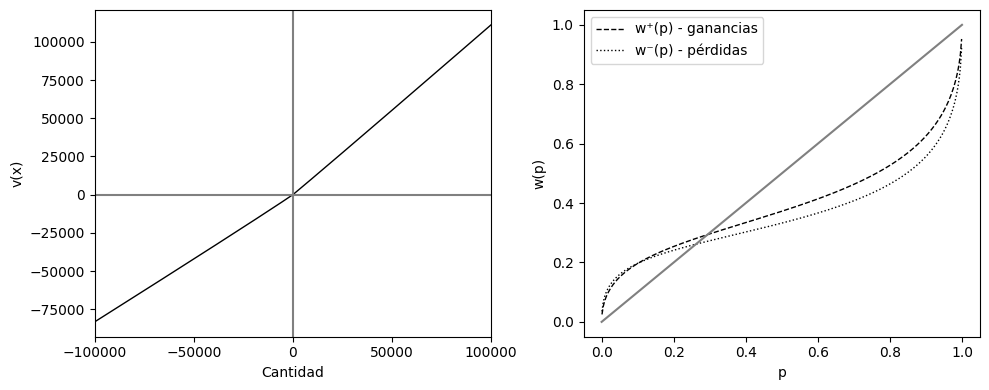

In [4]:
#Parámetros optimizados
alpha, beta, lam, gamma, delta = res.x

x_vals = np.linspace(-100000, 100000, 400)
v_vals = v_of_x(x_vals, alpha, beta, lam)
p_vals = np.linspace(0.001, 0.999, 300)
w_plus  = w_transform(p_vals, gamma)
w_minus = w_transform(p_vals, delta)

plt.figure(figsize=(10, 4))
#V(x)
plt.subplot(1, 2, 1)
plt.plot(x_vals, v_vals, linewidth=1, color='black')
plt.axhline(0, color='grey')
plt.axvline(0, color='grey')
plt.xlim(-100000, 100000)
plt.xticks([-100000, -50000, 0, 50000, 100000])
#plt.title("Función de Valor v(x)")
plt.xlabel("Cantidad")
plt.ylabel("v(x)")

plt.subplot(1, 2, 2)
plt.plot(p_vals, w_plus, '--', label="w⁺(p) - ganancias", linewidth=1, color='black')
plt.plot(p_vals, w_minus, ':', label="w⁻(p) - pérdidas", linewidth=1, color='black')
plt.plot([0,1],[0,1], color='gray')
#plt.title("Ponderación de Probabilidades para Ganancias y Pérdidas")
plt.xlabel("p")
plt.ylabel("w(p)")
plt.legend()

plt.tight_layout()
plt.show()

R²: 0.975732128889716


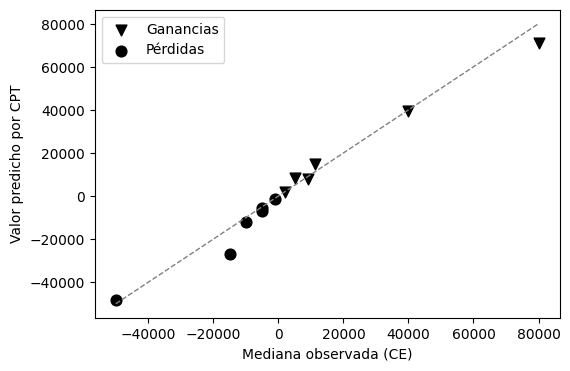

In [5]:
# Validación
grupos = defaultdict(list)

for d in data:
    key = (tuple(d["outcomes"]), tuple(d["probs"]))
    grupos[key].append(d["CE"])

real_vals = []
pred_vals = []
colores = []

for key, ces in grupos.items():
    outcomes, probs = key

    # mediana observada
    mediana = np.median(ces)
    real_vals.append(mediana)

    # predicción CPT
    pred = prospect_value(outcomes, probs, res.x[0], res.x[1], res.x[2], res.x[3], res.x[4])
    pred_vals.append(pred)

    # dominio: ganancia o pérdida
    if all(np.array(outcomes) >= 0):
        colores.append("blue")   # Ganancia
    elif all(np.array(outcomes) <= 0):
        colores.append("red")    # Pérdida
    else:
        colores.append("green")  # caso mixto (por si acaso)


real_vals_arr = np.array(real_vals)
pred_vals_arr = np.array(pred_vals)
colores = np.array(colores)
mask_gain = colores == 'blue'
mask_loss = colores == 'red'

# Cálculo de R²
ss_res = np.sum((real_vals_arr - pred_vals_arr)**2)
ss_tot = np.sum((real_vals_arr - np.mean(real_vals_arr))**2)
R2 = 1 - ss_res / ss_tot
print("R²:", R2)

plt.figure(figsize=(6, 4))
plt.scatter(real_vals_arr[mask_gain], pred_vals_arr[mask_gain], s=60, c='black', marker='v', label="Ganancias")
# pérdidas
plt.scatter(real_vals_arr[mask_loss], pred_vals_arr[mask_loss], s=60, c='black', marker='o', label="Pérdidas")
# Línea de identidad
minv = min(real_vals_arr.min(), pred_vals_arr.min())
maxv = max(real_vals_arr.max(), pred_vals_arr.max())
plt.plot([minv, maxv], [minv, maxv], '--', color='gray', linewidth=1)
plt.xlabel("Mediana observada (CE)")
plt.ylabel("Valor predicho por CPT")
#plt.title("Mediana observada vs Predicciones (Ganancias vs Pérdidas)")
plt.legend()
plt.show()
